In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from tqdm import tqdm
import cv2

def read_record(record: str, preprocess=lambda x:x, phase: str="train") -> tuple:
    with h5py.File(f'./{phase}/{record}.hdf5','r') as g:
        f = g[record]
        dfl = pd.DataFrame(data=np.array(f['L1']['SFTs']).T, columns=f['frequency_Hz'])
        dfl['timestamp'] = f['L1']['timestamps_GPS']
        dfh = pd.DataFrame(data=np.array(f['H1']['SFTs']).T, columns=f['frequency_Hz'])
        dfh['timestamp'] = f['H1']['timestamps_GPS']
    dfl['interferometer'] = 'L1'
    dfh['interferometer'] = 'H1'
    df = pd.concat([dfh, dfl])
    df = df.set_index(['interferometer', 'timestamp'])
    df = df.sort_index()
    return preprocess(df)

def projected_stats(df):
    h = df.loc['H1'].apply(lambda x: np.abs(x)).sum(axis=0).describe()[1:].rename('h_{}'.format)
    l = df.loc['L1'].apply(lambda x: np.abs(x)).sum(axis=0).describe()[1:].rename('l_{}'.format)
    hl = pd.concat([h, l]).T
    return hl

def read_wrapper(x):
    return read_record(x, projected_stats)

def read_extract(id_target_train, parallel=True, read_func=read_record):
    """
    read_record should be a wrapper function as the one above
    """
    if parallel:
        try:
            n = multiprocessing.cpu_count()
        except NotImplementedError:
            n = 4 # default
        pool = multiprocessing.Pool(n)
        df = pd.DataFrame(pool.map(read_func, id_target_train.index), index=id_target_train.index)
    else:
        df = pd.DataFrame([read_func(x) for x in id_target_train.index], index=id_target_train.index)
    return df.sort_index()

Read data while extracting features for the baseline

In [6]:
id_target_train = pd.read_csv("./train/_labels.csv", index_col="id")

# remove -1 labels
id_target_train = id_target_train[id_target_train["target"]!=-1]

df = read_extract(id_target_train, read_func=read_wrapper)
df


,h_mean,h_std,h_min,h_25%,h_50%,h_75%,h_max,l_mean,l_std,l_min,l_25%,l_50%,l_75%,l_max
id,,,,,,,,,,,,,,
001121a05,6.128137e-19,4.600262e-21,6.015902e-19,6.096676e-19,6.130792e-19,6.158436e-19,6.244663e-19,6.187054e-19,4.837818e-21,6.062285e-19,6.150891e-19,6.186779e-19,6.220764e-19,6.329838e-19
004f23b2d,6.042129e-19,4.832457e-21,5.913979e-19,6.008567e-19,6.039909e-19,6.075459e-19,6.170386e-19,6.157019e-19,4.833327e-21,6.017530e-19,6.126810e-19,6.154902e-19,6.189393e-19,6.291277e-19
00a6db666,6.018412e-19,5.093215e-21,5.898399e-19,5.982605e-19,6.017953e-19,6.051649e-19,6.157276e-19,6.113160e-19,4.797241e-21,5.962468e-19,6.079284e-19,6.112615e-19,6.141961e-19,6.253855e-19
00f36a6ac,6.126041e-19,4.980963e-21,5.971192e-19,6.094467e-19,6.128912e-19,6.157527e-19,6.290326e-19,6.072115e-19,4.883226e-21,5.941347e-19,6.039272e-19,6.073914e-19,6.107713e-19,6.214906e-19
010a387db,6.149985e-19,4.831152e-21,5.999003e-19,6.114386e-19,6.150762e-19,6.180529e-19,6.280269e-19,6.017033e-19,5.155971e-21,5.884113e-19,5.980565e-19,6.014921e-19,6.052093e-19,6.193454e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe38dbe64,6.067491e-19,4.550031e-21,5.932160e-19,6.038716e-19,6.064349e-19,6.094476e-19,6.204599e-19,5.916542e-19,4.620474e-21,5.775827e-19,5.885073e-19,5.914563e-19,5.944625e-19,6.033082e-19
feafd0d16,6.087672e-19,4.885521e-21,5.917042e-19,6.057575e-19,6.087067e-19,6.121019e-19,6.222068e-19,6.235617e-19,5.171303e-21,6.071034e-19,6.195809e-19,6.236623e-19,6.271045e-19,6.391801e-19
feeca844e,6.020778e-19,4.842306e-21,5.902151e-19,5.986663e-19,6.020239e-19,6.048582e-19,6.163814e-19,6.210237e-19,4.908842e-21,6.067751e-19,6.177095e-19,6.210094e-19,6.244864e-19,6.340535e-19


Add precomputed autocorrelation features

In [7]:
corr1 = pd.read_csv("./kxys.csv", index_col=0, usecols=[1, 2, 3]) # first file
corr2 = pd.read_csv("./kxys1.csv", index_col=0, usecols=[1, 2, 3]) # second file
corr = pd.concat([corr1, corr2])
corr.columns = ['H1_corr', 'L1_corr']
df_corr = df.join(corr, how='inner')
df_corr

,h_mean,h_std,h_min,h_25%,h_50%,h_75%,h_max,l_mean,l_std,l_min,l_25%,l_50%,l_75%,l_max,H1_corr,L1_corr
001121a05,6.128137e-19,4.600262e-21,6.015902e-19,6.096676e-19,6.130792e-19,6.158436e-19,6.244663e-19,6.187054e-19,4.837818e-21,6.062285e-19,6.150891e-19,6.186779e-19,6.220764e-19,6.329838e-19,1.241527e-50,-5.830280e-49
004f23b2d,6.042129e-19,4.832457e-21,5.913979e-19,6.008567e-19,6.039909e-19,6.075459e-19,6.170386e-19,6.157019e-19,4.833327e-21,6.017530e-19,6.126810e-19,6.154902e-19,6.189393e-19,6.291277e-19,4.655313e-50,1.407687e-50
00a6db666,6.018412e-19,5.093215e-21,5.898399e-19,5.982605e-19,6.017953e-19,6.051649e-19,6.157276e-19,6.113160e-19,4.797241e-21,5.962468e-19,6.079284e-19,6.112615e-19,6.141961e-19,6.253855e-19,-1.155415e-49,-6.803840e-50
00f36a6ac,6.126041e-19,4.980963e-21,5.971192e-19,6.094467e-19,6.128912e-19,6.157527e-19,6.290326e-19,6.072115e-19,4.883226e-21,5.941347e-19,6.039272e-19,6.073914e-19,6.107713e-19,6.214906e-19,-6.539164e-50,-2.113767e-51
010a387db,6.149985e-19,4.831152e-21,5.999003e-19,6.114386e-19,6.150762e-19,6.180529e-19,6.280269e-19,6.017033e-19,5.155971e-21,5.884113e-19,5.980565e-19,6.014921e-19,6.052093e-19,6.193454e-19,-2.544967e-50,6.083091e-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe38dbe64,6.067491e-19,4.550031e-21,5.932160e-19,6.038716e-19,6.064349e-19,6.094476e-19,6.204599e-19,5.916542e-19,4.620474e-21,5.775827e-19,5.885073e-19,5.914563e-19,5.944625e-19,6.033082e-19,1.571324e-50,3.643409e-50
feafd0d16,6.087672e-19,4.885521e-21,5.917042e-19,6.057575e-19,6.087067e-19,6.121019e-19,6.222068e-19,6.235617e-19,5.171303e-21,6.071034e-19,6.195809e-19,6.236623e-19,6.271045e-19,6.391801e-19,1.280130e-50,-2.702871e-50
feeca844e,6.020778e-19,4.842306e-21,5.902151e-19,5.986663e-19,6.020239e-19,6.048582e-19,6.163814e-19,6.210237e-19,4.908842e-21,6.067751e-19,6.177095e-19,6.210094e-19,6.244864e-19,6.340535e-19,8.589514e-50,2.807242e-52
ff5ad023f,6.001471e-19,4.554033e-21,5.869253e-19,5.969548e-19,5.999893e-19,6.032502e-19,6.124702e-19,6.103983e-19,4.758527e-21,5.965714e-19,6.068419e-19,6.104478e-19,6.137570e-19,6.264607e-19,4.248236e-52,-3.210572e-50


Baseline: Logistic Regression

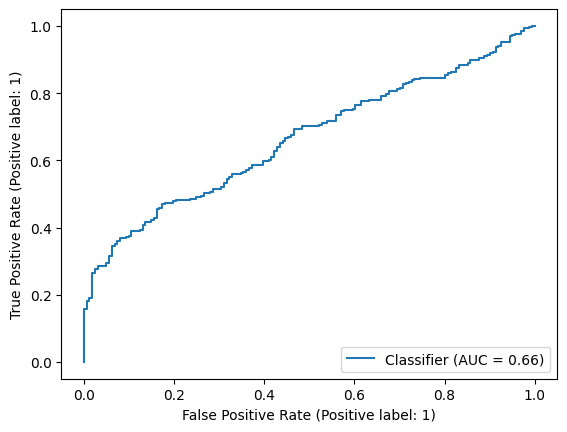

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler

labels = id_target_train['target']
labels = labels[labels.index.isin(df_corr.index)]

X_train, X_test, y_train, y_test = train_test_split(df_corr, labels, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(class_weight='balanced', random_state=42)

score = cross_val_score(clf, X_train, y_train, cv=KFold(n_splits=5, random_state=42, shuffle=True), scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1)
predicts = cross_val_predict(clf, X_train, y_train, cv=KFold(n_splits=5, random_state=42, shuffle=True), n_jobs=-1, method='predict_proba')

clf.fit(X_train, y_train)

y1 = [x[1] for x in predicts]
RocCurveDisplay.from_predictions(y_train, y1)

In [18]:
print(f"Score = {score.mean():.3f}\n")
f = [(x, y) for x, y in zip(df_corr.columns, clf.coef_.tolist()[0])]
print("Feature importances:")
sorted(f, key=lambda f:np.abs(f[1]), reverse=True)

Score = 0.668

Feature importances:


[('h_max', 1.272075913004129),
 ('l_max', 1.1564855218091155),
 ('l_std', 0.49669182753410557),
 ('l_min', -0.3655281403158287),
 ('h_std', 0.3654930741726779),
 ('L1_corr', -0.3276160400945494),
 ('l_50%', -0.2922705076494499),
 ('h_25%', -0.2691437183480181),
 ('H1_corr', 0.21630258305803143),
 ('h_mean', -0.18004295646654087),
 ('h_min', -0.1639988616628186),
 ('h_50%', -0.14511277853230414),
 ('l_75%', -0.12682447875561037),
 ('l_25%', 0.09213337667229364),
 ('h_75%', -0.05355342918957116),
 ('l_mean', 0.04545182458045352)]